<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/mlp/lrschedule_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Illustrate various learning rate schedules
Based on 
https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

try:
    import tensorflow
except ModuleNotFoundError:
    %pip install -qq tensorflow
    import tensorflow
import tensorflow as tf
from tensorflow import keras

assert tf.__version__ >= "2.0"


K = tf.keras.backend

In [4]:
def save_fig(fname, *args, **kwargs):
    """Save current plot window to the figures directory."""
    if "PYPROBML" in os.environ:
        root = os.environ["PYPROBML"]
        figdir = os.path.join(root, "figures")
    else:
        figdir = "../figures"
        print("cannot find environment variable PYPROBML, writing to {}".format(figdir))
    if not os.path.exists(figdir):
        os.mkdir(figdir)
    fname_full = os.path.join(figdir, fname)
    print("saving image to {}".format(fname_full))
    plt.tight_layout()
    plt.savefig(fname_full, *args, **kwargs)

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
# There are 60k training examples. For speed, we use 10k for training
# and 10k for validation.
n_train = 1000
n_valid = 1000
X_valid, X_train = X_train_full[:n_valid], X_train_full[n_valid : n_valid + n_train]
y_valid, y_train = y_train_full[:n_valid], y_train_full[n_valid : n_valid + n_train]

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [5]:
n_epochs = 20
lr0 = 0.01
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)


def make_model(lr0=0.01, momentum=0.9):
    optimizer = tf.keras.optimizers.SGD(lr=lr0, momentum=momentum)
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=[28, 28]),
            tf.keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
            tf.keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
            tf.keras.layers.Dense(10, activation="softmax"),
        ]
    )
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model


# Power scheduling
# lr = lr0 / (1+ steps/s)**c
# Keras.optimizer.SGD uses power scheduling with c=1 and s=1/decay


def power_decay(lr0, s, c=1):
    def power_decay_fn(epoch):
        return lr0 / (1 + epoch / s) ** c

    return power_decay_fn


power_schedule = tf.keras.callbacks.LearningRateScheduler(power_decay(lr0=lr0, s=20))

# Exponential scheduling
# lr = lr0 * 0.1**(epoch / s)


def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


exponential_schedule = tf.keras.callbacks.LearningRateScheduler(exponential_decay(lr0=lr0, s=20))

# Piecewise constant


def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)

    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]

    return piecewise_constant_fn


piecewise_schedule = tf.keras.callbacks.LearningRateScheduler(piecewise_constant([5, 15], [0.01, 0.005, 0.001]))

# Performance scheduling
perf_schedule = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)


# Make plots
schedules = {
    "power": power_schedule,
    "exp": exponential_schedule,
    "piecewise": piecewise_schedule,
    "perf": perf_schedule,
}


def ema(y, beta):
    """Exponentially weighted average."""
    n = len(y)
    zs = np.zeros(n)
    z = 0
    for i in range(n):
        z = beta * z + (1 - beta) * y[i]
        zs[i] = z
    return zs

Epoch 1/20
32/32 [==============================] - 1s 9ms/step - loss: nan - accuracy: 0.0888 - val_loss: nan - val_accuracy: 0.1070
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.1070
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0793 - val_loss: nan - val_accuracy: 0.1070
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0859 - val_loss: nan - val_accuracy: 0.1070
Epoch 5/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0871 - val_loss: nan - val_accuracy: 0.1070
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.1070
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0805 - val_loss: nan - val_accuracy: 0.1070
Epoch 8/20
32/32 [==============================] - 0s 5ms/ste

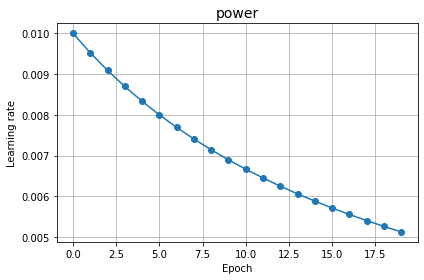

Epoch 1/20
32/32 [==============================] - 1s 9ms/step - loss: nan - accuracy: 0.0888 - val_loss: nan - val_accuracy: 0.1070
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.1070
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0793 - val_loss: nan - val_accuracy: 0.1070
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0859 - val_loss: nan - val_accuracy: 0.1070
Epoch 5/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0871 - val_loss: nan - val_accuracy: 0.1070
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.1070
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0805 - val_loss: nan - val_accuracy: 0.1070
Epoch 8/20
32/32 [==============================] - 0s 5ms/ste

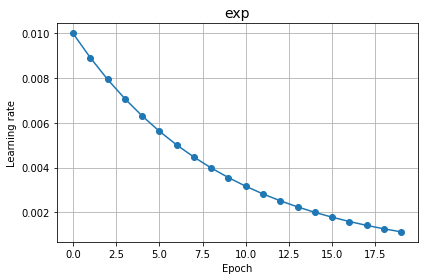

Epoch 1/20
32/32 [==============================] - 1s 9ms/step - loss: nan - accuracy: 0.0888 - val_loss: nan - val_accuracy: 0.1070
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.1070
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0793 - val_loss: nan - val_accuracy: 0.1070
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0859 - val_loss: nan - val_accuracy: 0.1070
Epoch 5/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0871 - val_loss: nan - val_accuracy: 0.1070
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.1070
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0805 - val_loss: nan - val_accuracy: 0.1070
Epoch 8/20
32/32 [==============================] - 0s 5ms/ste

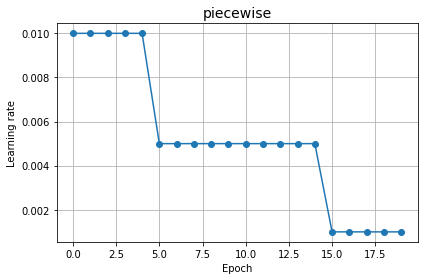

Epoch 1/20
32/32 [==============================] - 1s 9ms/step - loss: nan - accuracy: 0.0888 - val_loss: nan - val_accuracy: 0.1070
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.1070
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0793 - val_loss: nan - val_accuracy: 0.1070
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0859 - val_loss: nan - val_accuracy: 0.1070
Epoch 5/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0871 - val_loss: nan - val_accuracy: 0.1070
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.1070
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0805 - val_loss: nan - val_accuracy: 0.1070
Epoch 8/20
32/32 [==============================] - 0s 5ms/ste

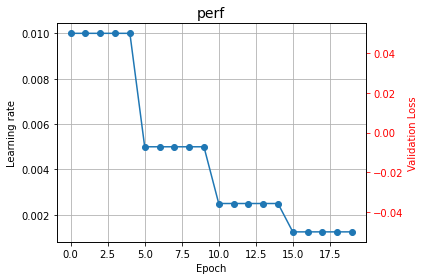

In [6]:
for name, lr_scheduler in schedules.items():
    tf.random.set_seed(42)
    np.random.seed(42)
    model = make_model()
    history = model.fit(
        X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid), callbacks=[lr_scheduler]
    )
    plt.figure()
    plt.plot(history.epoch, history.history["lr"], "o-")
    # plt.axis([0, n_epochs - 1, 0, 0.011])
    plt.xlabel("Epoch")
    plt.ylabel("Learning rate")
    plt.title(name, fontsize=14)
    plt.grid(True)

    if name == "perf":
        ax2 = plt.gca().twinx()
        hist = history.history["val_loss"]
        ax2.plot(history.epoch, hist, "r^-")
        ax2.set_ylabel("Validation Loss", color="r")
        ax2.tick_params("y", colors="r")

        # plt.figure()
        # plt.plot(history.epoch, ema(hist, 0.95))

    fname = "lrschedule-{}.pdf".format(name)
    save_fig(fname)
    plt.show()

# One-cycle heuristic

Illustrate the learning rate finder and 1cycle heuristic from Leslie Smith
It is described in this WACV'17 paper (https://arxiv.org/abs/1506.01186)
and this  blog post:
https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

The code below is modified from 
[here](https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb)


It trains an MLP on FashionMNIST


Epoch 1/5
8/8 [==============================] - 0s 27ms/step - loss: nan - accuracy: 0.0870 - val_loss: nan - val_accuracy: 0.1070
Epoch 2/5
8/8 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.0870 - val_loss: nan - val_accuracy: 0.1070
Epoch 3/5
8/8 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.0870 - val_loss: nan - val_accuracy: 0.1070
Epoch 4/5
8/8 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.0870 - val_loss: nan - val_accuracy: 0.1070
Epoch 5/5
8/8 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.0870 - val_loss: nan - val_accuracy: 0.1070
cannot find environment variable PYPROBML, writing to ../figures
saving image to ../figures/lrschedule-onecycle.pdf


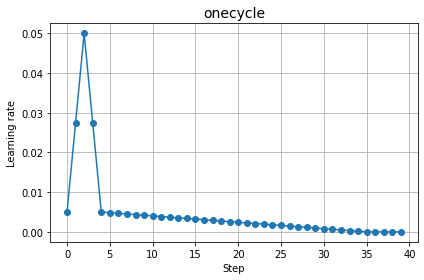

In [16]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None, last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        # self.half_iteration = (iterations - self.last_iterations) // 2
        self.half_iteration = self.last_iterations // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
        self.rate_hist = []

    def _interpolate_broken(self, iter1, iter2, rate1, rate2):
        return (rate2 - rate1) * (iter2 - self.iteration) / (iter2 - iter1) + rate1

    def _interpolate(self, iter1, iter2, rate1, rate2):
        return (rate2 - rate1) * (self.iteration - iter1) / (iter2 - iter1) + rate1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration, self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations, self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)
        self.rate_hist.append(K.get_value(self.model.optimizer.lr))


# https://stackoverflow.com/questions/48198031/keras-add-variables-to-progress-bar/48206009#48206009
n_epochs = 5
n_steps_per_epoch = len(X_train) // batch_size
onecycle = OneCycleScheduler(n_steps_per_epoch * n_epochs, max_rate=0.05)
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[onecycle],
)
# lr_hist = history.history["lr"] # only stored by LRScheduler
lr_hist = onecycle.rate_hist

plt.figure()
plt.plot(lr_hist, "o-")
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.title("onecycle", fontsize=14)
plt.grid(True)
save_fig("lrschedule-onecycle.pdf")
plt.show()

# Loss vs learning rate

In [17]:
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)


def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses


def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale("log")
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")


tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="elu"),
        keras.layers.Dense(100, activation="elu"),
        keras.layers.Dense(10, activation="softmax"),
    ]
)
"""
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
"""
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=1e-3), metrics=["accuracy"])

batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)

8/8 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.0902


In [18]:
print(rates)
print(losses)

[1e-05, 7.196856e-05, 0.0005179474, 0.0037275932, 0.026826954, 0.19306974, 1.3894953, 9.999998]
[nan, nan, nan, nan, nan, nan, nan, nan]


In [ ]:
plt.figure()
plot_lr_vs_loss(rates, losses)
save_fig("lrfinder-raw.pdf")
plt.show()

# https://sites.google.com/site/hardwaremonkey/blog/ewmafilterexmpleusingpandasandpython
# x = np.linspace(0, 2 * np.pi, 100)
# y = 2 * np.sin(x) + 0.1 * np.random.normal(x)
x = rates
y = np.array(losses, dtype=np.float64)
df = pd.Series(y)
filtered = pd.Series.ewm(df, span=10).mean()
plt.figure()  # figsize=(10,6))
plt.plot(x, y)
# plt.plot(x, filtered)
plt.gca().set_xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
save_fig("lrfinder-unfiltered.pdf")
plt.show()

plt.figure()  # figsize=(10,6))
# plt.plot(x, y)
plt.plot(x, filtered)
plt.gca().set_xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
save_fig("lrfinder-filtered.pdf")
plt.show()

plt.figure()  # figsize=(10,6))
plt.plot(x, y)
plt.plot(x, filtered)
plt.gca().set_xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
save_fig("lrfinder-filtered-both.pdf")
plt.show()